# 1. Basic imports and settings

In [35]:
import os
import sys
import argparse
sys.path.append("/mnt/8t/jjr/Structural-DPP-IV")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# from model import StructuralDPPIV
from config import load_config
from config.load_constant import constant
from data import StructuralEncode
from data import Encode
from util import util_draw

config_dict = load_config.load_default_args_dict("StructuralDPPIV")
config_dict['max_epochs'] = 150
config_dict['gpus'] = [3]  # using which GPU to train
config_dict['batch_size'] = 32
config_dict['lr'] = 0.000005
config_dict['model'] = 'StructuralDPPIV'
config_dict['log_dir'] = constant['path_log']
config_dict['max_seq_len'] = 90
args = argparse.Namespace(**config_dict)

In [36]:
class StructuralDPPIV(nn.Module):
    def __init__(self, config):
        super(StructuralDPPIV, self).__init__()
        self.StructEncodeModule = Structural(config)
        self.TextCNN = TextCNN()

        self.classification = nn.Sequential(
            nn.Linear(1024, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.Ws = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)
        self.Wh = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)

    def forward(self, x):
        TextCNN_Only = False
        StructuralEncodingOnly = False
        assert not (TextCNN_Only and StructuralEncodingOnly)
        if not TextCNN_Only and not StructuralEncodingOnly:
            TextCNNEncode = self.TextCNN(x[0])
            StructedEncode = self.StructEncodeModule(x[1])
            newEncode = TextCNNEncode * StructedEncode
            output = self.classification(newEncode)
            return output, newEncode
        elif TextCNN_Only:
            TextCNNEncode = self.TextCNN(x[0])
            output = self.classification(TextCNNEncode)
            return output, TextCNNEncode
        elif StructuralEncodingOnly:
            StructedEncode = self.StructEncodeModule(x[1])
            output = self.classification(StructedEncode)
            return output, StructedEncode


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.visualization = False
        vocab_size = 24
        dim_embedding = 100
        print(f"[INFO] using CNN config of {dataset_name}")
        # filter_sizes = [1, 2, 4, 8, 16, 24, 32, 48, 64]
        filter_sizes = [1, 2]
        filter_num = 90
        self.embedding = nn.Embedding(vocab_size, dim_embedding)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, filter_num, (fsz, dim_embedding)) for fsz in filter_sizes])
        self.linear = nn.Linear(filter_num * len(filter_sizes), 1024)

    def forward(self, x):
        # print("\nx = \n", x)
        x = self.embedding(x)
        x = x.view(x.size(0), 1, x.size(1), -1)
        x = [F.relu(conv(x)) for conv in self.convs]

        x = [F.max_pool2d(input=x_item, kernel_size=(x_item.size(2), x_item.size(3))) for x_item in x]
        x = [x_item.view(x_item.size(0), -1) for x_item in x]
        embedding = torch.cat(x, 1)
        embedding = self.linear(embedding)

        return embedding


class Structural(nn.Module):
    def __init__(self, config):
        super(Structural, self).__init__()
        self.config = config
        self.inpuchannel = [32, 32, 64]
        global dataset_name
        dataset_name = 'DPP-IV'
        print(f"[INFO] using Structural config of {dataset_name}")
        self.embedding_dim = 21
        global max_seq_len
        max_seq_len = config.max_seq_len
        self.conv = torch.nn.Conv2d(self.embedding_dim, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        # self.conv = torch.nn.Conv2d(19, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        self.resBlock1 = resBlock(self.inpuchannel[0], self.inpuchannel[1])
        self.resBlock2 = resBlock(self.inpuchannel[1], self.inpuchannel[2], increDimen=True)
        self.linear = nn.Linear(23552, 1024)

    def forward(self, graph):
        # 90 is the max length of sequence, 15 is the number of amino acid, 21 is the number of channel
        graph = graph.cuda()  # (batchSize, 90, 15, 21)
        graph = graph.transpose(2, 3)  # (batchSize, 90, 21, 15)
        graph = graph.transpose(1, 2)   # (batchSize, 21, 90, 15)
        representation = self.conv(graph) # (batchSize, 32, 90, 15)
        representation = self.resBlock1(representation) # (batchSize, 32, 90, 15)
        representation = self.resBlock2(representation) # (batchSize, 64, 46, 8)
        representation = representation.flatten(start_dim=1) # (batchSize, 23552)
        representation = self.linear(representation) # (batchSize, 1024)
        return representation


class resBlock(nn.Module):
    def __init__(self, inputchannel, outputchannel, increDimen=False):
        super(resBlock, self).__init__()
        self.increDimen = increDimen
        self.inputchannel = inputchannel
        self.outputchannel = outputchannel
        padding_dim1 = 2 if max_seq_len % 2 == 0 else 1
        self.conv = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=(2, 2), padding=(padding_dim1, 1))
        self.conv1 = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(inputchannel, affine=True)
        self.conv2 = torch.nn.Conv2d(outputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(outputchannel, affine=True)

    def forward(self, feature):
        original = feature

        if self.increDimen:
            feature = F.max_pool2d(input=feature, kernel_size=(2, 2), padding=1)
            original = self.conv(original)
        feature = self.batchnorm1(feature)
        feature = F.relu(feature)
        feature = self.conv1(feature)
        feature = self.batchnorm2(feature)
        feature = F.relu(feature)
        feature = self.conv2(feature)
        feature = feature + original
        return feature

In [37]:
def load_params(model, param_path):
    pretrained_dict = torch.load(param_path)['state_dict']
    # print(pretrained_dict.keys())
    new_model_dict = model.state_dict()
    # print(new_model_dict.keys())
    pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in pretrained_dict.items() if '.'.join(k.split('.')[1:]) in new_model_dict}
    # pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in new_model_dict}
    print(pretrained_dict.keys())
    new_model_dict.update(pretrained_dict)
    model.load_state_dict(new_model_dict)

In [38]:
def get_one_sequence_code(sequence = 'YPFPGPIP'):
    # sequence = 'YPFPGPIP'

    sequence_data_process = Encode.codePeptides([sequence])
    sequence_data_length = len(sequence_data_process[0])
    sequence_data_padding = np.pad(sequence_data_process[0], (0, 90 - sequence_data_length), 'constant', constant_values=0)
    sequence_data = torch.tensor(np.array([sequence_data_padding])).cuda()

    Channel = StructuralEncode.convert_to_graph_channel(sequence)
    Structure_data = StructuralEncode.convert_to_graph_channel_returning_maxSeqLenx15xfn(Channel, cubeBiased=False,
                                                                 maxSeqLen=90, cubeBias=False,
                                                                 right_align=False)
    tensor_Structure_data = torch.tensor(Structure_data).cuda()
    tensor_Structure_data = torch.unsqueeze(tensor_Structure_data, 0)

    # sequence_data = sequence_data_process.cuda()
    # print(sequence_data)
    return [sequence_data, tensor_Structure_data]

In [39]:
def load_tsv(filename, skip_head=True):
    sequences = []
    labels = []
    with open(filename, 'r') as file:
        if skip_head:
            next(file)
        for line in file:
            if line[-1] == '\n':
                line = line[:-1]
            list = line.split('\t')
            sequences.append(list[2])
            labels.append(int(list[1]))
    return sequences, labels

In [40]:
new_model = StructuralDPPIV(args).cuda()
load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_3/checkpoints/epoch=73,step=2442,val_SE_epoch=0.95,val_SP_epoch=0.87,val_F1_epoch=0.91,val_AUC_epoch=1.00.ckpt')

[INFO] using Structural config of DPP-IV
[INFO] using CNN config of DPP-IV
dict_keys(['Ws', 'Wh', 'StructEncodeModule.conv.weight', 'StructEncodeModule.conv.bias', 'StructEncodeModule.resBlock1.conv.weight', 'StructEncodeModule.resBlock1.conv.bias', 'StructEncodeModule.resBlock1.conv1.weight', 'StructEncodeModule.resBlock1.conv1.bias', 'StructEncodeModule.resBlock1.batchnorm1.weight', 'StructEncodeModule.resBlock1.batchnorm1.bias', 'StructEncodeModule.resBlock1.batchnorm1.running_mean', 'StructEncodeModule.resBlock1.batchnorm1.running_var', 'StructEncodeModule.resBlock1.batchnorm1.num_batches_tracked', 'StructEncodeModule.resBlock1.conv2.weight', 'StructEncodeModule.resBlock1.conv2.bias', 'StructEncodeModule.resBlock1.batchnorm2.weight', 'StructEncodeModule.resBlock1.batchnorm2.bias', 'StructEncodeModule.resBlock1.batchnorm2.running_mean', 'StructEncodeModule.resBlock1.batchnorm2.running_var', 'StructEncodeModule.resBlock1.batchnorm2.num_batches_tracked', 'StructEncodeModule.resBlock2.

In [155]:
new_model.eval()
DATA = get_one_sequence_code('NYIVPEDKREMWMACIAELH')
output, embedding = new_model(DATA)
pred_prob_all = F.softmax(output, dim=1)  # predict probability [batch_size, class_num]
pred_prob_all

tensor([[0.9917, 0.0083]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [42]:
pred_prob = []
label_pred = []
predict_true = 0

sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
# sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/train/train.tsv')
from tqdm import tqdm
# predict sequence one by one
for index in tqdm(range(len(sequences))):
    # print("before success2:", config.learn_name)
    sequence_code = get_one_sequence_code(sequences[index])
    logits, representation = new_model(sequence_code)

    pred_prob_all = F.softmax(logits, dim=1)  # predict probability [batch_size, class_num]
    pred_prob_positive = pred_prob_all[:, 1]  # note, it is very easy to make mistake
    pred_prob_sort = torch.max(pred_prob_all, 1)  # max probability in each sample [batch_size]
    pred_class = pred_prob_sort[1]  # where max probability site in each sample [batch_size]

    pred_prob = pred_prob + pred_prob_positive.tolist()
    label_pred = label_pred + pred_class.tolist()

acc = accuracy_score(labels, label_pred)
auc = roc_auc_score(labels, pred_prob)
f1 = f1_score(labels, label_pred)
se = recall_score(labels, label_pred)
sp = recall_score(labels, label_pred, pos_label=0)

print('acc:', acc)
print('auc:', auc)
print('f1:', f1)
print('se:', se)
print('sp:', sp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:03<00:00, 85.40it/s]

acc: 0.9097744360902256
auc: 0.9657414212222284
f1: 0.9130434782608695
se: 0.9473684210526315
sp: 0.8721804511278195


# 2. Perturbation analysis

In [43]:
aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
           'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 17, 'T': 19,
           'W': 20, 'Y': 21, 'V': 22, 'X': 23}
aa_list = list(aa_dict.keys())
aa_list.remove('X')

In [164]:
import copy
def perturbation_process():
    sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')

    save_data_abs = []
    save_data_normal = []
    iter_sequences = sequences

    for k in tqdm(range(len(iter_sequences))):
        iter_sequence_origin = iter_sequences[k]
        iter_sequence_len = len(iter_sequence_origin)
        result_matrix_abs = np.zeros((len(aa_list), len(iter_sequence_origin)))
        result_matrix_normal = np.zeros((len(aa_list), len(iter_sequence_origin)))

        sequence_code_origin = get_one_sequence_code(iter_sequence_origin)
        with torch.no_grad():
            output, feature = new_model(sequence_code_origin)
        output = torch.softmax(output, dim=1)[0][1].item()

        for i in range(0, iter_sequence_len):
            for j in range(len(aa_list)):
                iter_sequence_perturbation = copy.copy(iter_sequence_origin)
                iter_sequence_perturbation = iter_sequence_perturbation[:i] + aa_list[j] + iter_sequence_perturbation[i + 1:]
                sequence_code_perturbation = get_one_sequence_code(iter_sequence_perturbation)
                with torch.no_grad():
                    output_perturbation, feature = new_model(sequence_code_perturbation)
                output_perturbation = torch.softmax(output_perturbation, dim=1)[0][1].item()

                # 计算差异
                # diff = output_modification - output
                diff_abs = abs(output_perturbation - output)
                diff_normal = output_perturbation - output

                result_matrix_abs[j][i] = diff_abs
                result_matrix_normal[j][i] = diff_normal
        save_data_abs.append([result_matrix_abs, iter_sequence_origin])
        save_data_normal.append([result_matrix_normal, iter_sequence_origin])

    torch.save(save_data_abs, '/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/abs_test.pt')
    torch.save(save_data_normal, '/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/normal_test.pt')

In [165]:
perturbation_process()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [14:55<00:00,  3.37s/it]


In [167]:
perturbation_abs_data_sequences = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/abs_test.pt')
perturbation_normal_data_sequences = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/normal_test.pt')

In [174]:
len(perturbation_abs_data_sequences)

266

# 2.1 position importance

In [203]:
cut_number = 25
sequences_position_value = [[] for i in range(cut_number)]
all_sequences = perturbation_abs_data_sequences
for sequence_data in all_sequences:
    matrix = sequence_data[0]
    result_matrix = matrix.sum(axis = 0)
    # matrix = matrix * -1
    # matrix = matrix.tolist()
    # print(result_matrix)
    sequence_position_value = [0 for i in range(cut_number)]
    if len(result_matrix) < cut_number:
        for i in range(len(sequence_position_value)):
            position = int(i / cut_number * len(result_matrix))
            if position == len(result_matrix):
                position = len(result_matrix) - 1
            # print(result_matrix[position].item())
            # print(position)
            sequence_position_value[i] += result_matrix[position].item()
    elif len(result_matrix) >= cut_number:
        for i in range(len(result_matrix)):
            position = int(i / len(result_matrix) * cut_number)
            if position == cut_number:
                position = cut_number - 1
            sequence_position_value[position] += result_matrix[i].item()


    for i in range(len(sequences_position_value)):
        sequences_position_value[i].append(sequence_position_value[i])

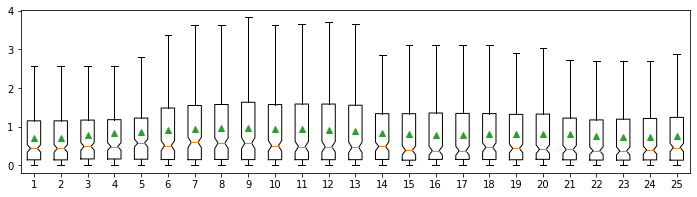

In [204]:
import matplotlib.pyplot as plt
def plot_box_now(data, keys):

#     plt.grid(b=None)

    plt.figure(figsize=(12, 3))  # 画布
    ax=plt.axes()
    ax.grid(False)
    ax.boxplot(data,
                keys,  # 为箱线图添加标签，类似于图例的作用
                '',
#                 sym="g+",  # 异常点形状，默认为蓝色的“+”
                showmeans=True  # 是否显示均值，默认不显示
                )

    plt.show()
plot_box_now(sequences_position_value, [i for i in range(cut_number)])

In [202]:
sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
print(labels.index(0))
len(labels)

133


266

# 2.2 not cut sequence

In [207]:
# not cut sequence
sequences_position_origin_value = [0 for i in range(90)]
sequences_position_origin_count = [1 for i in range(90)]
for sequence_data in all_sequences:
    matrix = sequence_data[0]
    result_matrix = matrix.sum(axis = 0)

    for i in range(len(result_matrix)):
        sequences_position_origin_value[i] += result_matrix[i].item()
        sequences_position_origin_count[i] = sequences_position_origin_count[i] + 1

for i in range(len(sequences_position_origin_value)):
    sequences_position_origin_value[i] = sequences_position_origin_value[i] / sequences_position_origin_count[i]


In [208]:
print(sequences_position_origin_count)

[267, 267, 216, 202, 197, 178, 157, 146, 138, 124, 112, 103, 94, 86, 83, 56, 48, 44, 34, 33, 16, 15, 14, 13, 11, 11, 11, 11, 11, 10, 8, 8, 8, 7, 7, 7, 6, 5, 5, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


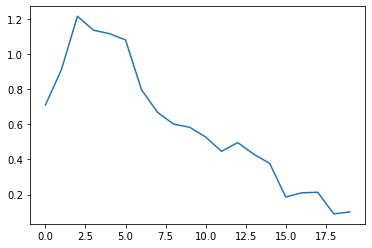

In [209]:
plt.plot(sequences_position_origin_value[:20])

# 3. amino acid analysis
## 3.1. abs_data

In [210]:
perturbation_abs_data_sequences = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/abs_test.pt')
perturbation_normal_data_sequences = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/normal_test.pt')

In [213]:
abs_negative = perturbation_abs_data_sequences[labels.index(0):]
aa_value_each_negative_sequence = []
for sequence_data in abs_negative:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_negative_sequence.append(matrix)

abs_aa_value_origin_negative_sequence = np.array(aa_value_each_negative_sequence).sum(axis=0)
for i in range(len(abs_aa_value_origin_negative_sequence)):
    abs_aa_value_negative = (abs_aa_value_origin_negative_sequence - np.min(abs_aa_value_origin_negative_sequence)) / (
            np.max(abs_aa_value_origin_negative_sequence) - np.min(abs_aa_value_origin_negative_sequence))

In [214]:
abs_positive = perturbation_abs_data_sequences[:labels.index(0)]
aa_value_each_positive_sequence = []
for sequence_data in abs_positive:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_positive_sequence.append(matrix)

abs_aa_value_origin_positive_sequence = np.array(aa_value_each_positive_sequence).sum(axis=0)
for i in range(len(abs_aa_value_origin_positive_sequence)):
    abs_aa_value_positive = (abs_aa_value_origin_positive_sequence - np.min(abs_aa_value_origin_positive_sequence)) / (
            np.max(abs_aa_value_origin_positive_sequence) - np.min(abs_aa_value_origin_positive_sequence))

In [215]:
count_aa_neg = 0
count_aa_pos = 0
for sequence in sequences[:labels.index(0)]:
    count_aa_pos += len(sequence)
for sequence in sequences[labels.index(0):]:
    count_aa_neg += len(sequence)
print(count_aa_pos)
print(count_aa_neg)

706
2065


In [216]:
abs_aa_value_origin_avg_positive_sequence = abs_aa_value_origin_positive_sequence / count_aa_pos
abs_aa_value_origin_avg_negative_sequence = abs_aa_value_origin_negative_sequence / count_aa_neg

In [217]:
for i in range(len(aa_list)):
    # print(aa_list[i],abs_aa_value_positive[i], abs_aa_value_negative[i])
    print(aa_list[i], abs_aa_value_origin_positive_sequence[i], abs_aa_value_origin_negative_sequence[i])
    print(aa_list[i], abs_aa_value_origin_avg_positive_sequence[i], abs_aa_value_origin_avg_negative_sequence[i])
    print("==================================")


A 37.28889890015125 51.39230017056252
A 0.052817137252338886 0.024887312431265143
R 67.55943594872952 69.65590276470175
R 0.09569325205202481 0.0337316720410178
N 37.621699035167694 53.16975567611371
N 0.053288525545563306 0.025748065702718502
D 35.37339295446873 52.69961123209214
D 0.05010395602615967 0.02552039284847077
C 39.75159692764282 49.61146239528898
C 0.05630537808447992 0.02402492125679854
Q 32.98174495995045 62.32208435684879
Q 0.04671635263449072 0.030180186129224598
E 40.3029819726944 59.483377323929744
E 0.05708637673186175 0.028805509599965976
G 41.238871455192566 54.67182070670242
G 0.05841199922831808 0.02647545796934742
H 50.0004627853632 55.391026240366045
H 0.0708221852483898 0.026823741520758376
I 40.47763633728027 53.85540417519951
I 0.05733376251739415 0.026080098874188624
L 30.723435133695602 51.600191354431445
L 0.04351761350381814 0.024987986128053967
K 45.093177780508995 55.92077710165904
K 0.06387135662961614 0.02708027946811576
M 34.404613107442856 59.7379

## 3.2. normal_data

In [218]:
normal_negative = perturbation_normal_data_sequences[labels.index(0):]
aa_value_each_negative_sequence = []
for sequence_data in normal_negative:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_negative_sequence.append(matrix)

normal_aa_value_origin_negative_sequence = np.array(aa_value_each_negative_sequence).sum(axis=0)
for i in range(len(normal_aa_value_origin_negative_sequence)):
    normal_aa_value_negative = (normal_aa_value_origin_negative_sequence - np.min(normal_aa_value_origin_negative_sequence)) / (
            np.max(normal_aa_value_origin_negative_sequence) - np.min(normal_aa_value_origin_negative_sequence))

In [219]:
normal_positive = perturbation_normal_data_sequences[:labels.index(0)]
aa_value_each_positive_sequence = []
for sequence_data in normal_positive:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_positive_sequence.append(matrix)

normal_aa_value_origin_positive_sequence = np.array(aa_value_each_positive_sequence).sum(axis=0)
for i in range(len(normal_aa_value_origin_positive_sequence)):
    normal_aa_value_positive = (normal_aa_value_origin_positive_sequence - np.min(normal_aa_value_origin_positive_sequence)) / (
            np.max(normal_aa_value_origin_positive_sequence) - np.min(normal_aa_value_origin_positive_sequence))

In [224]:
normal_aa_value_origin_avg_positive_sequence = normal_aa_value_origin_positive_sequence / count_aa_pos
normal_aa_value_origin_avg_negative_sequence = normal_aa_value_origin_negative_sequence / count_aa_neg

In [225]:
for i in range(len(aa_list)):
    # print(aa_list[i],normal_aa_value_positive[i], normal_aa_value_negative[i], normal_aa_value_origin_positive_sequence[i], normal_aa_value_origin_negative_sequence[i])
    print(aa_list[i],normal_aa_value_origin_positive_sequence[i], normal_aa_value_origin_negative_sequence[i])
    print(aa_list[i],normal_aa_value_origin_avg_positive_sequence[i], normal_aa_value_origin_avg_negative_sequence[i])
    print("==================================")

A -10.61808954179287 1.8109338471185765
A -0.015039786886392166 0.0008769655433988264
R -60.20052649080753 -34.6636873773823
R -0.08526986755071889 -0.016786289286867942
N -13.307335764169693 -2.5158114519363153
N -0.018848917512988235 -0.0012183106304776345
D -4.818351045250893 2.7573376438813284
D -0.006824859837465854 0.001335272466770619
C -25.47967156767845 -15.014921125082765
C -0.03609018635648506 -0.007271148244592138
Q -8.51264674961567 29.80525851215498
Q -0.012057573299738908 0.014433539231067787
E -6.662897616624832 16.51188045753952
E -0.009437532034879365 0.007996068018178943
G -15.741430759429932 10.15349012929073
G -0.022296644135169876 0.004916944372537884
H -38.94452349841595 -24.355556799127953
H -0.05516221458699143 -0.011794458498367048
I -20.47167694568634 -19.428900634251477
I -0.028996709554796517 -0.009408668588015243
L 6.794733792543411 20.406983352761017
L 0.009624268827965172 0.00988231639358887
K -31.606817081570625 -16.04841031801334
K -0.04476886272177143

# 3.3 AAC

In [94]:
def read_sequence(path):
    positive_sequences = []
    negative_sequences = []

    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                line = line.split('\t')
                if line[1] == '1':
                    positive_sequences.append(line[2])
                else:
                    negative_sequences.append(line[2])
    return positive_sequences, negative_sequences


def AAC_frequency(data):
    frequency = {}
    frequency_list = []
    num = 0
    for i in data:
        seq = i
        for a in seq:
            if a in frequency.keys():
                frequency[a] += 1
            else:
                frequency[a] = 1
            num += 1

    name_list = aa_list
    output_list = {}
    all_f = 0
    for i, order in enumerate(name_list):
        frequency_list.append(frequency[order])
        output_list[order] = frequency[order] / num
        all_f += frequency[order] / num

    return output_list

positive_sequences, negative_sequences = read_sequence('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
AAC_frequency_positive = AAC_frequency(positive_sequences)
AAC_frequency_negative = AAC_frequency(negative_sequences)
AAC_frequency_all = AAC_frequency(sequences)
print(AAC_frequency_negative)
print(AAC_frequency_positive)

{'A': 0.08104196816208394, 'R': 0.056439942112879886, 'N': 0.03569705740472745, 'D': 0.04003859141341052, 'C': 0.03907380607814761, 'Q': 0.036661842739990354, 'E': 0.05451037144235408, 'G': 0.07284129281234925, 'H': 0.02604920405209841, 'I': 0.06222865412445731, 'L': 0.08345393150024119, 'K': 0.08055957549445249, 'M': 0.019778099372889532, 'F': 0.0472744814278823, 'P': 0.06849975880366618, 'S': 0.056439942112879886, 'T': 0.03907380607814761, 'W': 0.010130246020260492, 'Y': 0.028461167390255667, 'V': 0.05788712011577424}
{'A': 0.05240793201133145, 'R': 0.0339943342776204, 'N': 0.0339943342776204, 'D': 0.029745042492917848, 'C': 0.009915014164305949, 'Q': 0.060906515580736544, 'E': 0.04815864022662889, 'G': 0.053824362606232294, 'H': 0.029745042492917848, 'I': 0.05240793201133145, 'L': 0.10623229461756374, 'K': 0.039660056657223795, 'M': 0.026912181303116147, 'F': 0.042492917847025496, 'P': 0.1501416430594901, 'S': 0.039660056657223795, 'T': 0.04107648725212465, 'W': 0.0339943342776204, 

In [75]:
new_model.eval()
DATA = get_one_sequence_code('LMMMMMMGQIM')
output, embedding = new_model(DATA)
pred_prob_all = F.softmax(output, dim=1)  # predict probability [batch_size, class_num]
pred_prob_all

tensor([[0.2972, 0.7028]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# 3.4 analysis

In [232]:
scores_pos = {}
scores_neg = {}
scores_all = {}
for i in range(len(aa_list)):
    scores_pos[aa_list[i]] = normal_aa_value_origin_positive_sequence[i] / abs_aa_value_origin_positive_sequence[i]
    scores_neg[aa_list[i]] = normal_aa_value_origin_negative_sequence[i] / abs_aa_value_origin_negative_sequence[i]
    # scores_pos[aa_list[i]] = abs_aa_value_positive[i] * (normal_aa_value_positive[i] * normal_aa_value_positive[i])
    scores_all[aa_list[i]] = (normal_aa_value_origin_positive_sequence[i] + normal_aa_value_origin_negative_sequence[i]) / (abs_aa_value_origin_positive_sequence[i] + abs_aa_value_origin_negative_sequence[i])
    print(aa_list[i], scores_neg[aa_list[i]], scores_pos[aa_list[i]])

A 0.03523745465971337 -0.28475202687601486
R -0.4976417791106167 -0.8910750311250879
N -0.04731658853694024 -0.3537143750932241
D 0.052321783394906916 -0.13621399144415944
C -0.3026502425074363 -0.6409722762599298
Q 0.4782455339826832 -0.2581017699322013
E 0.27758814647696384 -0.1653202142992546
G 0.1857170659042269 -0.38171342240860134
H -0.4397022126551415 -0.7788832608528637
I -0.36076046465172595 -0.5057527760540637
L 0.39548270688745146 0.2211580105862368
K -0.28698475146078073 -0.7009223709053458
M 0.6030845144408308 0.48966177860955573
F -0.05372260443273007 -0.5112804408974977
P 0.7323751534432901 0.24133626101175612
S -0.028239021615707113 -0.3222324411196489
T -0.12712924262983072 -0.47274413413494876
W -0.6756515439354223 -0.8043930892630528
Y -0.6557779237457644 -0.8812936037370726
V -0.001484292166168291 -0.4409196724351967


In [236]:
aa_k_fold = {}
for i in range(len(aa_list)):
    aa_k_fold[aa_list[i]] = AAC_frequency_positive[aa_list[i]] / AAC_frequency_negative[aa_list[i]]

In [237]:
sorted(aa_k_fold.items(),key = lambda x:x[1],reverse = True)

[('W', 3.3557264265479567),
 ('P', 2.1918565215656547),
 ('Q', 1.661305352616669),
 ('Y', 1.3934796178038125),
 ('M', 1.3607061424721896),
 ('V', 1.2968484419263457),
 ('L', 1.2729453568913853),
 ('H', 1.1418791312559018),
 ('T', 1.0512538033784495),
 ('N', 0.9523007426690147),
 ('F', 0.8988552928253454),
 ('E', 0.8834766476973601),
 ('I', 0.842183279530931),
 ('D', 0.7429093143110687),
 ('G', 0.7389265144550964),
 ('S', 0.7026948500036319),
 ('A', 0.6466764467826791),
 ('R', 0.6023098714316845),
 ('K', 0.4923071703618259),
 ('C', 0.25375091805686706)]

In [233]:
sorted(scores_all.items(),key = lambda x:x[1],reverse = True)

[('P', 0.5784817546539195),
 ('M', 0.5616339287259192),
 ('L', 0.33042418447427774),
 ('Q', 0.22341821850369295),
 ('E', 0.09870069326447393),
 ('D', -0.023401193366855266),
 ('G', -0.05826191537338599),
 ('A', -0.09931254636793452),
 ('S', -0.1535319236872997),
 ('N', -0.17428013755726157),
 ('V', -0.18019692605810167),
 ('F', -0.24707711758372267),
 ('T', -0.26938707531202494),
 ('I', -0.4229756335974263),
 ('C', -0.4531468931298074),
 ('K', -0.47176875170537974),
 ('H', -0.6006185213123846),
 ('R', -0.6913528382297692),
 ('W', -0.7364322231789581),
 ('Y', -0.7652040430795629)]

In [222]:
sorted(AAC_frequency_positive.items(),key = lambda x:x[1],reverse = True)

[('P', 0.1501416430594901),
 ('L', 0.10623229461756374),
 ('V', 0.07507082152974505),
 ('Q', 0.060906515580736544),
 ('G', 0.053824362606232294),
 ('A', 0.05240793201133145),
 ('I', 0.05240793201133145),
 ('E', 0.04815864022662889),
 ('F', 0.042492917847025496),
 ('T', 0.04107648725212465),
 ('K', 0.039660056657223795),
 ('S', 0.039660056657223795),
 ('Y', 0.039660056657223795),
 ('R', 0.0339943342776204),
 ('N', 0.0339943342776204),
 ('W', 0.0339943342776204),
 ('D', 0.029745042492917848),
 ('H', 0.029745042492917848),
 ('M', 0.026912181303116147),
 ('C', 0.009915014164305949)]

In [93]:
sorted(AAC_frequency_negative.items(),key = lambda x:x[1],reverse = True)

[('L', 0.08345393150024119),
 ('A', 0.08104196816208394),
 ('K', 0.08055957549445249),
 ('G', 0.07284129281234925),
 ('P', 0.06849975880366618),
 ('I', 0.06222865412445731),
 ('V', 0.05788712011577424),
 ('R', 0.056439942112879886),
 ('S', 0.056439942112879886),
 ('E', 0.05451037144235408),
 ('F', 0.0472744814278823),
 ('D', 0.04003859141341052),
 ('C', 0.03907380607814761),
 ('T', 0.03907380607814761),
 ('Q', 0.036661842739990354),
 ('N', 0.03569705740472745),
 ('Y', 0.028461167390255667),
 ('H', 0.02604920405209841),
 ('M', 0.019778099372889532),
 ('W', 0.010130246020260492)]